# Import and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import missingno as msno
import plotly.express as px

from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Feature Engineering (Seasonality + Lag variable)

In [3]:
def create_lag(df):
    df['year'] = pd.to_datetime(df['Date']).dt.year
    df['month'] = pd.to_datetime(df['Date']).dt.month
    df['day'] = pd.to_datetime(df['Date']).dt.day
    df['Date'] = pd.to_datetime(df['Date'])    
    df.set_index('Date', inplace=True)
    df.sort_values(by=['ID', 'Date'], inplace=True)
    for i in range(1, 15):
        df[f'lag{i}'] = df.groupby('ID')['GT_NO2'].shift(i)

    return df

In [4]:
trained = create_lag(train)

C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2887561755.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['year'] = pd.to_datetime(df['Date']).dt.year
C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2887561755.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['Date']).dt.month
C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2887561755.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['day'] = pd.to_datetime(df['Date']).dt.day
C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2887561755.py:5: UserWarning: Could not infer f

In [5]:
def full_df(df):
    df = df.copy().reset_index()
    df = df.drop(['ID', 'ID_Zindi', 'Date'],axis=1)
    return df

trained = full_df(trained)
trained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LAT                 86584 non-null  float64
 1   LON                 86584 non-null  float64
 2   Precipitation       86584 non-null  float64
 3   LST                 46798 non-null  float64
 4   AAI                 73709 non-null  float64
 5   CloudFraction       73709 non-null  float64
 6   NO2_strat           73709 non-null  float64
 7   NO2_total           73709 non-null  float64
 8   NO2_trop            51111 non-null  float64
 9   TropopausePressure  73709 non-null  float64
 10  GT_NO2              82051 non-null  float64
 11  year                86584 non-null  int32  
 12  month               86584 non-null  int32  
 13  day                 86584 non-null  int32  
 14  lag1                81972 non-null  float64
 15  lag2                81893 non-null  float64
 16  lag3

# Validation: Rolling Time Series

In [6]:
rts = TimeSeriesSplit(max_train_size=5000)

sub_set = trained.dropna(subset=['GT_NO2'])

x = sub_set.drop('GT_NO2', axis=1)
y = sub_set['GT_NO2']

In [7]:
models = [XGBRegressor(), LGBMRegressor()]
model_names = ['XGBRegressor', 'LGBMRegressor']
model_errors = []

for model, name in zip(models, model_names):
    errors = []
    print(f"Training {name}...")
    
    # Create a tqdm progress bar for the cross-validation splits
    for train_index, test_index in tqdm(rts.split(x), desc=f"Processing {name}", total=rts.get_n_splits()):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        error = mean_squared_error(y_test, y_pred, squared=False)
        errors.append(error)
    
    # Average error for the current model
    avg_error = sum(errors) / len(errors)
    model_errors.append({'model': name, 'error': avg_error})

# Convert to DataFrame for better visualization
model_errors_df = pd.DataFrame(model_errors)
print(model_errors_df)

Training XGBRegressor...


Processing XGBRegressor: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


Training LGBMRegressor...


Processing LGBMRegressor:  20%|██        | 1/5 [00:00<00:00,  6.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] Start training from score 22.990000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5673
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] Start training from score 20.000490


Processing LGBMRegressor:  60%|██████    | 3/5 [00:00<00:00,  8.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5673
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] Start training from score 34.561265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5673
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] Start training from score 26.724412


Processing LGBMRegressor: 100%|██████████| 5/5 [00:00<00:00,  8.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5671
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] Start training from score 26.589235
           model      error
0   XGBRegressor  11.020812
1  LGBMRegressor  10.852241


# Feature Importance 

C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2062524437.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('turbo')


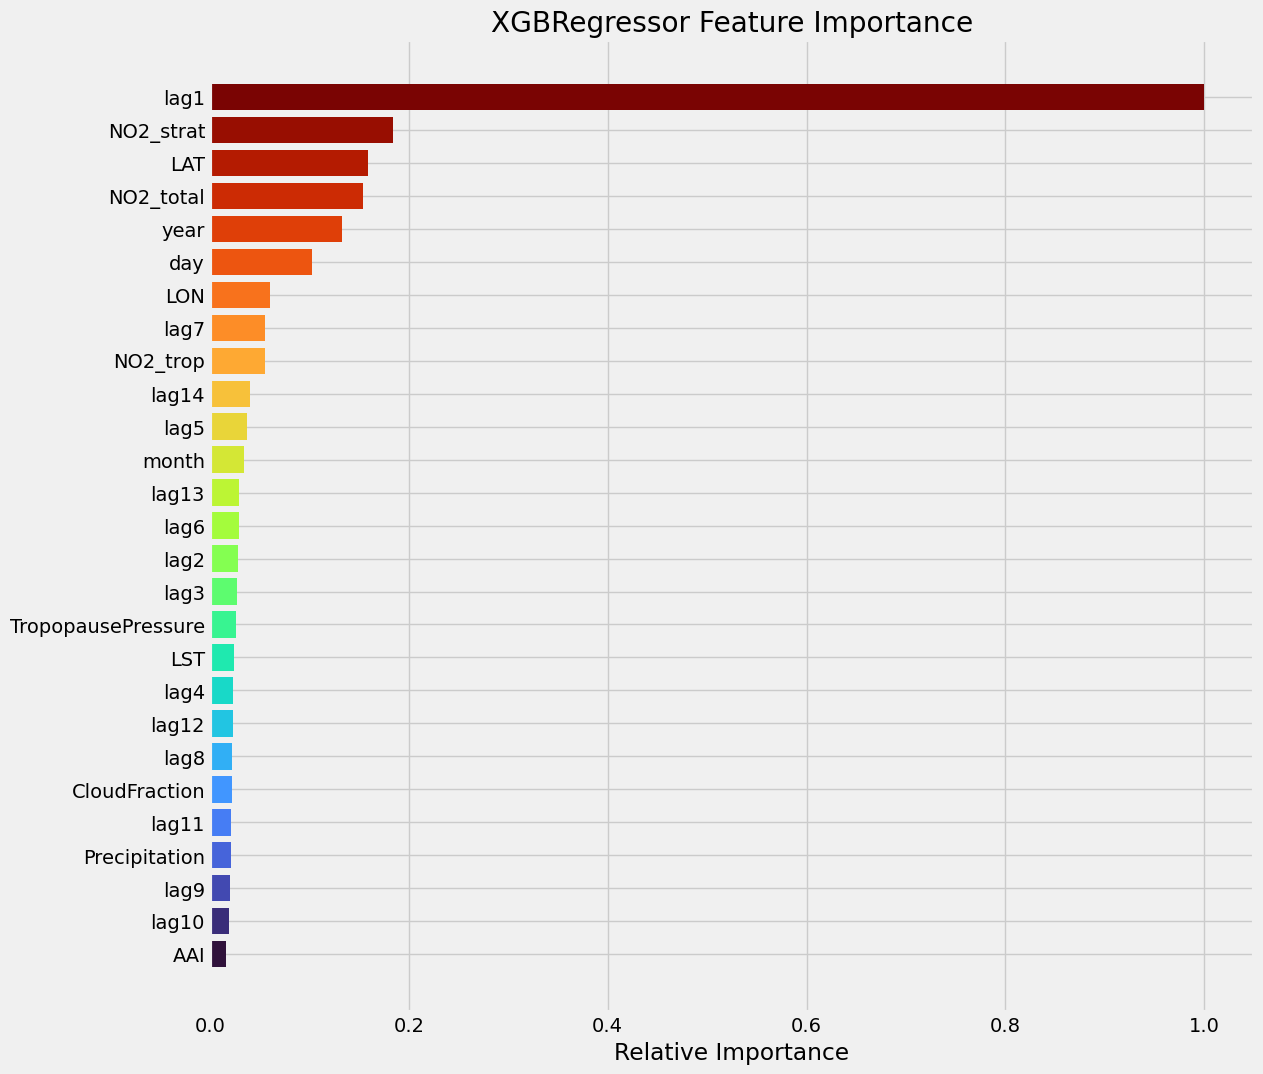

C:\Users\leeno\AppData\Local\Temp\ipykernel_14584\2062524437.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('turbo')


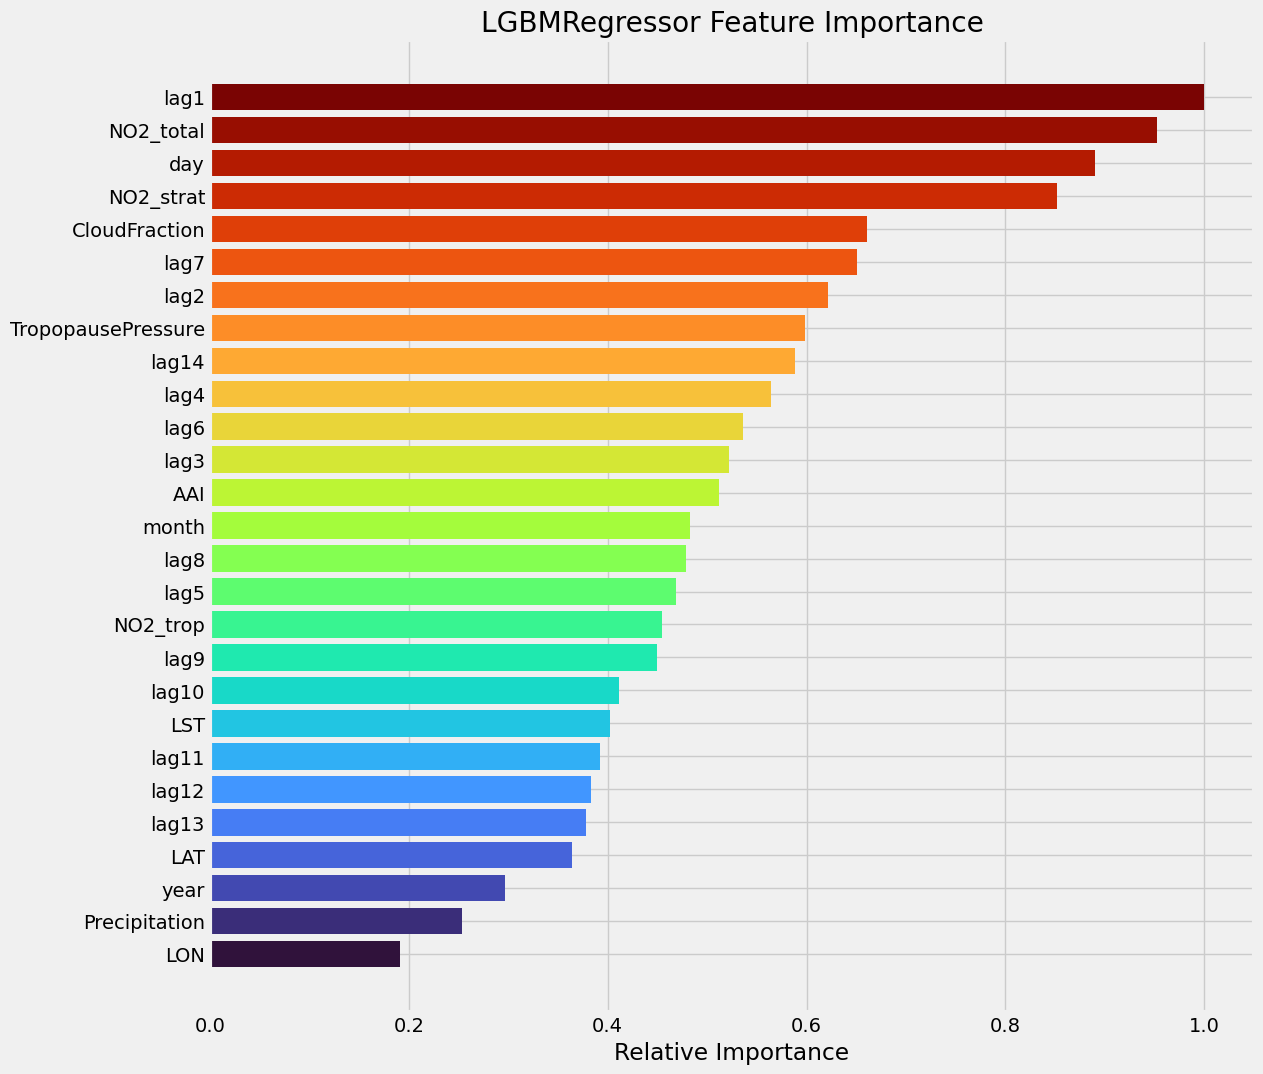

In [9]:
import matplotlib.cm as cm

for model, name in zip(models, model_names):
    
    feature_names = x.columns
    importances = model.feature_importances_
    #Normalize importances
    importances = importances / importances.max()
    indices = np.argsort(importances)

    cmap = cm.get_cmap('turbo')
    colors = cmap(np.linspace(0, 1, len(indices)))

    plt.figure(figsize=(12, 12))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices], color=colors, align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.title(f"{name} Feature Importance")
    plt.show()
